In [1]:
import numpy as np
import numpy.random as npr
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm_notebook
import math
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
torch.set_default_dtype(torch.float64)
%matplotlib inline

In [2]:
class feed_forward(nn.Module):
    def __init__(self, num_layers, width, d_in, nonlin='tanh', sigma_w=1, sigma_b=1):
        super().__init__()
        sequential = []
        self.num_layers = num_layers
        for layer in range(num_layers):
            if layer == 0:
                W = nn.Linear(d_in, width)
                W.weight.data = sigma_w * torch.randn(W.weight.data.shape) / math.sqrt(d_in)
                W.bias.data = sigma_b * torch.randn(W.bias.data.shape)

            else:
                W = nn.Linear(width, width)
                W.weight.data = sigma_w * torch.randn(W.weight.data.shape) / math.sqrt(width)
                W.bias.data = sigma_b * torch.randn(W.bias.data.shape)

            sequential.append(W)
            if nonlin == 'tanh':
                sequential.append(nn.Tanh())
            else:
                sequential.append(nn.ReLU())
        self.sequential = nn.Sequential(*sequential)

    def forward(self, x):
        hidden = []
        for layer in range(self.num_layers):
            if layer == 0:
                hidden.append(self.sequential[2 * layer: 2 * layer + 2](x))
            else:
                hidden.append(self.sequential[2 * layer: 2 * layer + 2](hidden[layer - 1]))
        return hidden

/Users/user/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


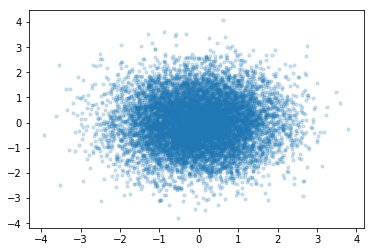

In [3]:
"Create data"
N = 10_000 # number of data points
d_in = 2
X = math.sqrt(1.01) * torch.randn(N, d_in)
fig = plt.figure()
if d_in == 2:
    ax = fig.add_subplot(111)
    ax.scatter(X[:, 0].numpy(), X[:, 1].numpy(), s=10, alpha=0.2)
    fig.show()
elif d_in == 3:        
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X[:, 0].numpy(), X[:, 1].numpy(), X[:, 2].numpy())
    fig.show()

In [4]:
network = feed_forward(num_layers=20, width=1000, d_in=2, nonlin='tanh', sigma_w=2, sigma_b=0.3)

In [5]:
with torch.no_grad():
    hiddens = network(X)

In [6]:
from numpy import newaxis as na
"Compute covariance matrices"
covs = []
for hidden in hiddens:
    temp = hidden.numpy()
    temp = temp - np.mean(temp, 0)[na, :]
    cov = temp.T @ temp / (N - 1)
    cov = (cov + cov.T) / 2
    covs.append(cov)
    

In [7]:
power_law = np.array([1/(n + 1) for n in range(1_000)])
power_law /= np.sum(power_law)

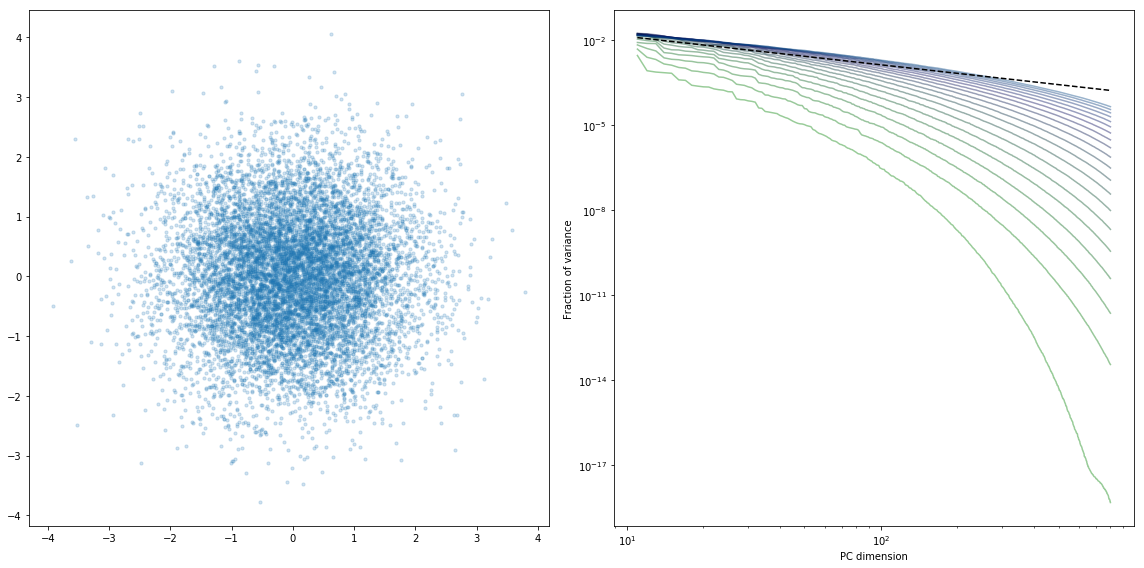

In [8]:
import matplotlib
cmap = matplotlib.cm.get_cmap('ocean')
alphas = np.linspace(0, 0.5, len(covs))
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(121)
ax.scatter(X[:, 0].numpy(), X[:, 1].numpy(), s=10, alpha=0.2)

ax = fig.add_subplot(122)
start = 10
stop = 800
for idx in range(len(covs)):
    eigs, _ = np.linalg.eigh(covs[idx])
    eigs = eigs[::-1]
    eigs /= np.sum(eigs)
    ax.loglog(np.arange(start + 1, stop + 1), eigs[start:stop], color=cmap(alphas[idx]), alpha=0.4)
ax.loglog(np.arange(start + 1, stop + 1), power_law[start:stop], color='black', linestyle='--')
ax.set_ylabel('Fraction of variance')
ax.set_xlabel('PC dimension')
fig.tight_layout()

[1.00463531 1.00646109]
1.01
[[1.00939305 1.0012869 ]
 [1.0012869  1.01306523]]
[[1.00939305 1.0012869 ]
 [1.0012869  1.01306523]]


/Users/user/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


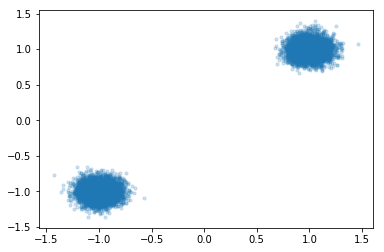

In [13]:
"Mixture of Gaussians"
import numpy.random as npr
N = 10_000
n, p = 1, 0.5
labels = np.random.binomial(n, p, N)
X = (np.zeros(N) == labels)[:, na] * (-1 + 0.1 * npr.randn(N, d_in)) + (np.ones(N) == labels)[:, na] * (1 + 0.1 * npr.randn(N, d_in))
std = np.std(X, 0)
print(std)
print(1 + 0.1 ** 2)
temp = X - np.mean(X, 0)[na, :]
emp_cov = temp.T @ temp / (N - 1)
emp_cov = (emp_cov + emp_cov.T) / 2
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(X[:, 0], X[:, 1], s=10, alpha=0.2)
fig.show()

In [14]:
with torch.no_grad():
    hiddens = network(torch.from_numpy(X))

In [15]:
from numpy import newaxis as na
"Compute covariance matrices"
covs = []
for hidden in hiddens:
    temp = hidden.numpy()
    temp = temp - np.mean(temp, 0)[na, :]
    cov = temp.T @ temp / (N - 1)
    cov = (cov + cov.T) / 2
    covs.append(cov)


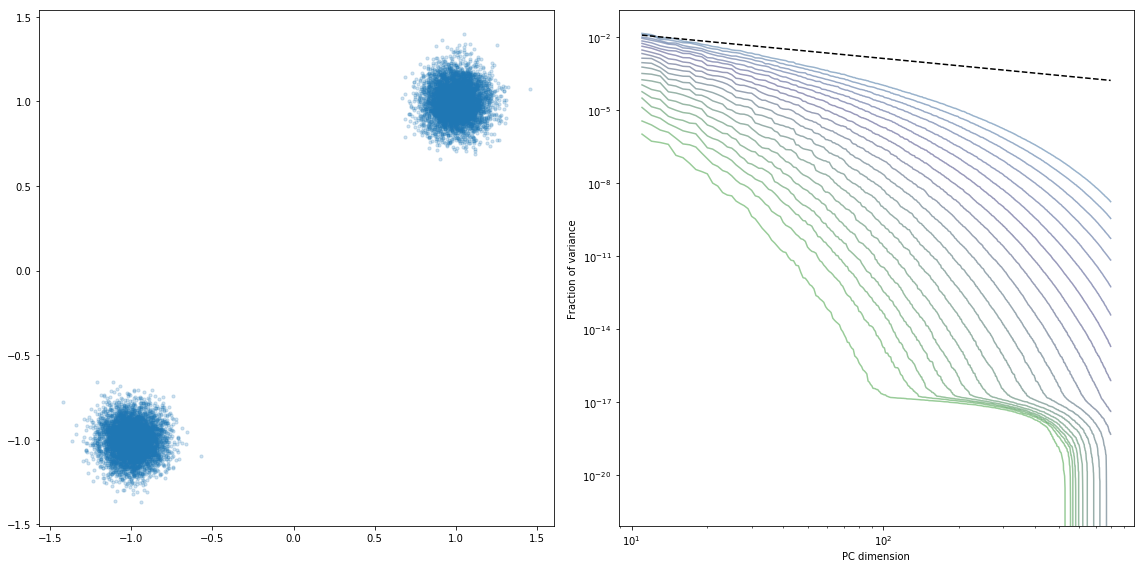

In [16]:
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(121)
ax.scatter(X[:, 0], X[:, 1], s=10, alpha=0.2)

ax = fig.add_subplot(122)
start = 10
stop = 800
for idx in range(len(covs)):
    eigs, _ = np.linalg.eigh(covs[idx])
    eigs = eigs[::-1]
    eigs /= np.sum(eigs)
    ax.loglog(np.arange(start + 1, stop + 1), eigs[start:stop], color=cmap(alphas[idx]), alpha=0.4)
ax.loglog(np.arange(start + 1, stop + 1), power_law[start:stop], color='black', linestyle='--')
ax.set_ylabel('Fraction of variance')
ax.set_xlabel('PC dimension')
fig.tight_layout()

[[1.00468555 0.        ]
 [0.9966172  0.14078131]]
[[1.00176943 0.99424418]
 [0.99424418 1.00676357]]
[[1.00939305 1.0012869 ]
 [1.0012869  1.01306523]]


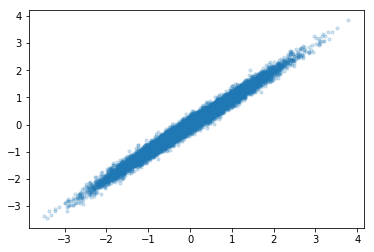

In [20]:
N = 10_000
n, p = 1, 0.5
chol = np.linalg.cholesky(emp_cov)
X = npr.randn(N, 2) @ chol.T
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(X[:, 0], X[:, 1], s=10, alpha=0.2)
fig.show()

In [21]:
with torch.no_grad():
    hiddens = network(torch.from_numpy(X))

In [22]:
from numpy import newaxis as na
"Compute covariance matrices"
covs = []
for hidden in hiddens:
    temp = hidden.numpy()
    temp = temp - np.mean(temp, 0)[na, :]
    cov = temp.T @ temp / (N - 1)
    cov = (cov + cov.T) / 2
    covs.append(cov)


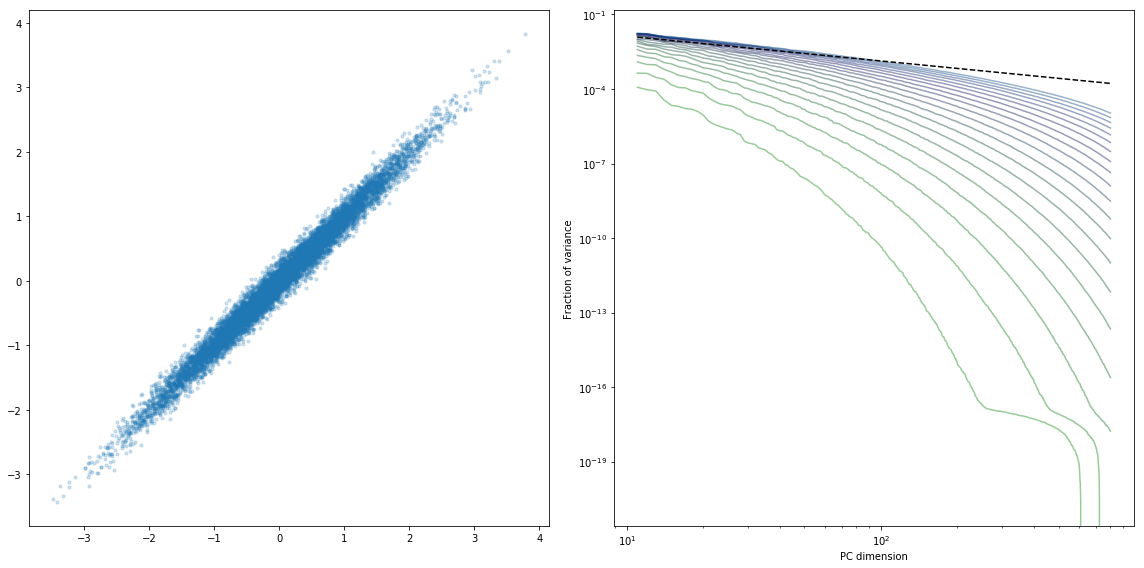

In [23]:
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(121)
ax.scatter(X[:, 0], X[:, 1], s=10, alpha=0.2)

ax = fig.add_subplot(122)
start = 10
stop = 800
for idx in range(len(covs)):
    eigs, _ = np.linalg.eigh(covs[idx])
    eigs = eigs[::-1]
    eigs /= np.sum(eigs)
    ax.loglog(np.arange(start + 1, stop + 1), eigs[start:stop], color=cmap(alphas[idx]), alpha=0.4)
ax.loglog(np.arange(start + 1, stop + 1), power_law[start:stop], color='black', linestyle='--')
ax.set_ylabel('Fraction of variance')
ax.set_xlabel('PC dimension')
fig.tight_layout()

In [ ]:
"Students t"
import numpy.random as npr
N = 10_000
X = npr.standard_t(df=3, size=(N, 2))
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(X[:, 0], X[:, 1], s=10, alpha=0.2)
fig.show()

In [ ]:
with torch.no_grad():
    hiddens = network(torch.from_numpy(X))

In [ ]:
from numpy import newaxis as na
"Compute covariance matrices"
covs = []
for hidden in hiddens:
    temp = hidden.numpy()
    temp = temp - np.mean(temp, 0)[na, :]
    cov = temp.T @ temp / (N - 1)
    cov = (cov + cov.T) / 2
    covs.append(cov)

In [ ]:
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(121)
ax.scatter(X[:, 0], X[:, 1], s=10, alpha=0.2)

ax = fig.add_subplot(122)
start = 10
stop = 800
for idx in range(len(covs)):
    eigs, _ = np.linalg.eigh(covs[idx])
    eigs = eigs[::-1]
    eigs /= np.sum(eigs)
    ax.loglog(np.arange(start + 1, stop + 1), eigs[start:stop], color=cmap(alphas[idx]), alpha=0.4)
ax.loglog(np.arange(start + 1, stop + 1), power_law[start:stop], color='black', linestyle='--')
ax.set_ylabel('Fraction of variance')
ax.set_xlabel('PC dimension')
fig.tight_layout()